# Titanic Analysis 4% Kaggle

## Package Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings(action='ignore')


from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')

## Load & Check data

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
IDtest = test['PassengerId']

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.describe(include = ['O']) # 범주형 데이터 확인

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [8]:
test.describe(include = ['O']) # 범주형 변수

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


### Outlier Detection

In [9]:
def detect_outliers(df,n,features) :
    outlier_indices = []
    for col in features :
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

outlier는 예측에 극적인 영향을 미칠 수 있으므로 관리하기로 결심 <br>
Tukey방법을 사용하여 1분위와 3분위 수 사이의 IQR 을 정의한 후 outlier 검출.

수치형 변수인 Age, SibSp, Parch, Fare 에서 Outlier을 검출한다.

In [10]:
Outliers_to_drop = detect_outliers(train,2,['Age', 'SibSp','Parch','Fare'])

# Outlier를 최소 두 개의 outlier가 있는 행으로 생각했다.

In [11]:
# outlier을 가지고 있는 행들
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [12]:
# outlier 삭제
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop = True)

In [13]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [14]:
# joining train and test set
# categorical 변환 중 동일한 수의 형상을 얻기 위해서 train 및 test dataset을 concat한다.
train_len = len(train) # 나중에 train & test 다시 분리를 위해서 len 을기억
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [15]:
# Check for null and missing values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Cabin에 Null값이 많다. 

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [17]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [18]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [19]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
876,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
877,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
878,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
879,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Feature Analysis

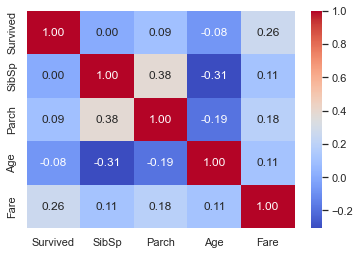

In [20]:
# 상관관계 확인
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), 
                annot = True, fmt = '.2f', #안에있는 숫자표시, 표시형식
                cmap = 'coolwarm')

일단 Fare만 Survived와 상관관계가 조금 있어보이지만 그것도 그렇게 큰 것은 아니다.

## SibSp - 형제자매

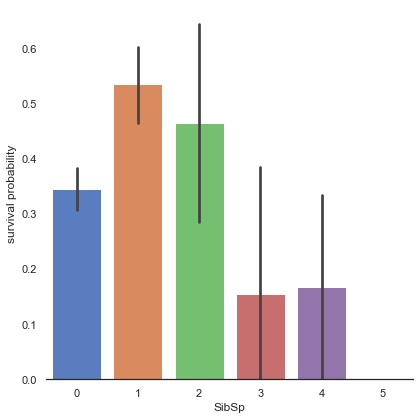

In [21]:
g= sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', size = 6,
                 palette = 'muted')
g.despine(left = True) # 살짝 벌리는 옵션
g = g.set_ylabels('survival probability')

1명인 승객들이 가장 많이 생존.<br>
혼자인 승객도 생존할 수 있는 기회가 꽤나 있다.<br>
이 관찰은 상당히 흥미로우며, 이러한 범주를 설명하는 새로운 특징을 고려할 수 있다.

## Parch

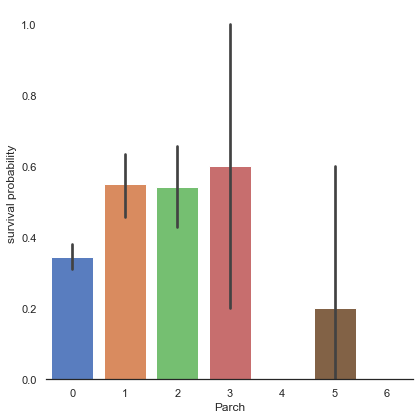

In [22]:
g = sns.factorplot(x = 'Parch', y='Survived', data = train, kind = 'bar', size = 6,
                  palette = 'muted' )
g.despine(left = True)
g = g.set_ylabels('survival probability')

걍 뭐 .. 비슷비슷하지만 5명이면 더 적게 살아남았다.<br>
부모, 자녀가 3명인 승객의 생존에 중요한 표준편차가 있을 수 있다. 

## Age

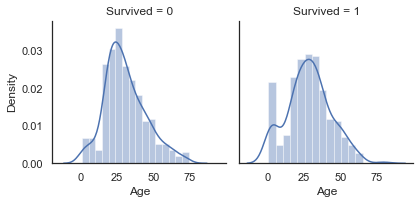

In [23]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

가우시안 분포같이 생긴 분포. <br>
생존자와 사망자의 인구에서 연령분포가 같지 않다는 것을 알아냈다.<br>
실제로 살아남은 사람들은 젊은승객쪽에 봉우리가 크다. 노인들이 살아남지 못했음을 뜻함. <br>
아주 어린 승객들은 특히나 생존률이 높은 것을 확인할 수 있다.

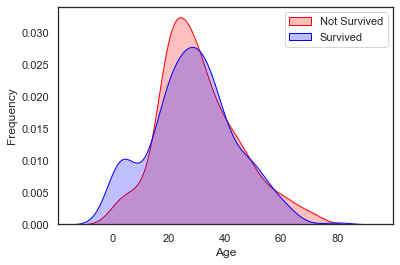

In [24]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red',shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

## Fare

In [25]:
dataset['Fare'].isnull().sum()

1

In [26]:
# 결측치가 있는데 1개이므로 그냥 대충 중앙값으로 메워주자.
dataset["Fare"] = dataset['Fare'].fillna(dataset['Fare'].median())

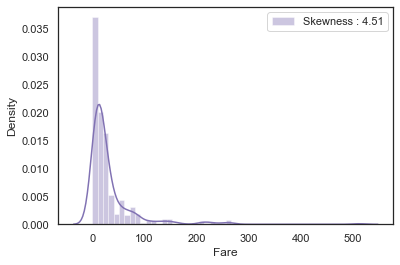

In [27]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

낮은 쪽으로 매우 치우친 그래프. <br>
이렇게 되면 크기가 조정되더라도 모형의 매우 높은 값이 초과될 수 있다.<br>
로그변환을 통해서 skew (왜도) 를 줄여준 뒤 사용하는 것이 필요할 것 같다.

In [28]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i>0 else 0)

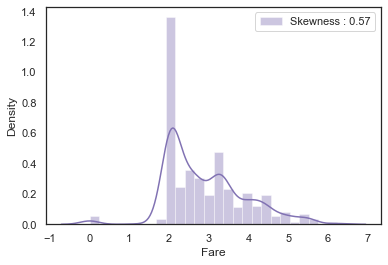

In [29]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

왜도가 줄어들었다.

## Categorical values

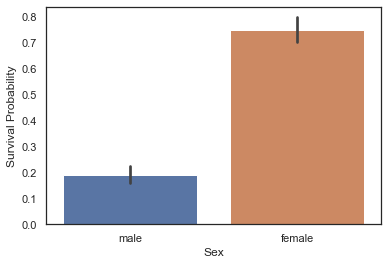

In [30]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

여자가 엄청나게 많이 살아남았다.

In [31]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존기회가 적다는 것은 명확하다. <br>
그래서 Sex는 생존을 예측하는데 중요한 역할을 할 수도 있다. <br>

## Pclass

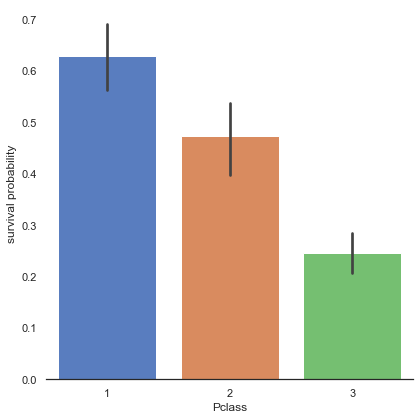

In [32]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', 
                  size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

1등급이 가장 높은 생존률을 보였다. <br>
등급이 낮아질수록 생존률도 낮아지는 것이 보인다. <br>
1등급이 가장 높은 계급일 것이라는 것이 유추가 가능하다.

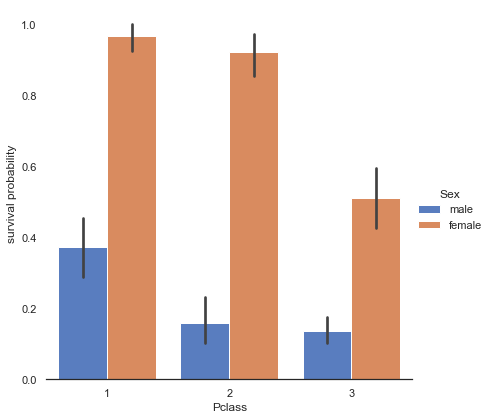

In [33]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar', 
                  size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

남녀 따라서도 비슷하다.

## Embarked - 탑승항구

In [34]:
dataset['Embarked'].isnull().sum()

2

In [35]:
dataset['Embarked'] = dataset['Embarked'].fillna('S') # 가장 높은 빈도를 보인 S로 대체해준다.

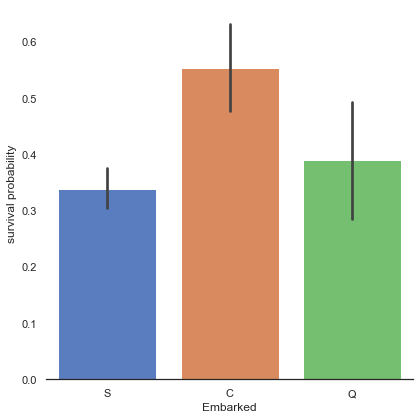

In [36]:
g = sns.factorplot(x = 'Embarked', y = 'Survived', data = train, kind = 'bar', 
                  size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

셰르부르 (C) 에서 탄 탑승객의 생존확률이 높았다. <br>
1등급 승객이 셰르부르에서 더 많이 탑승하지 않았을까 라는 가설을 세울 수 있다 .

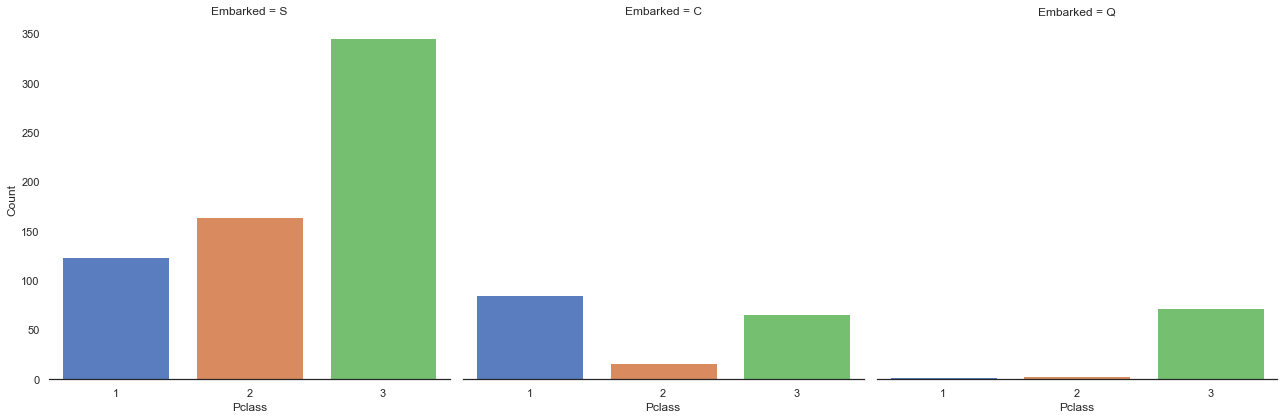

In [37]:
g = sns.factorplot("Pclass", col = 'Embarked', data = train,
                  size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels("Count")

우리가 예상했던 대로 1등급 승객들의 비율이 셰르부르가 많은 것을 알 수 있다.

## Filling Missing Values

In [38]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [39]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [40]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1007
Embarked          0
dtype: int64

### Age
Age 에는 256개의 결측값이 포함되어 있다. <br>
생존 기회가 더 많은 어린층이 있기 때문에 연령특징은 유지하고 누락된 가치를 귀속시켜야 함이 바람직하다. <br>
이 문제를 해결하기 위해서 Age 와 가장 상관관계가 있는 특징을 살펴보았다.

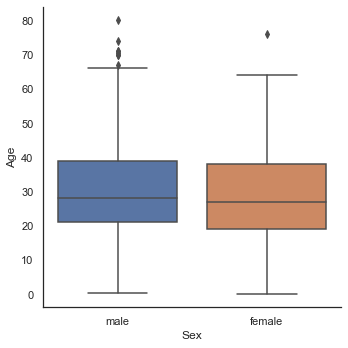

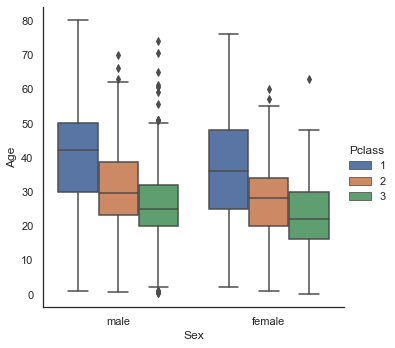

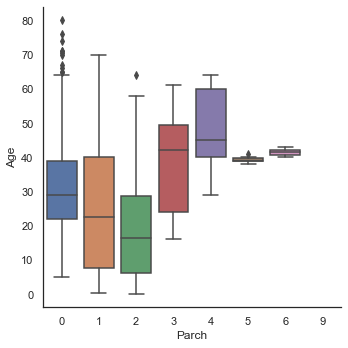

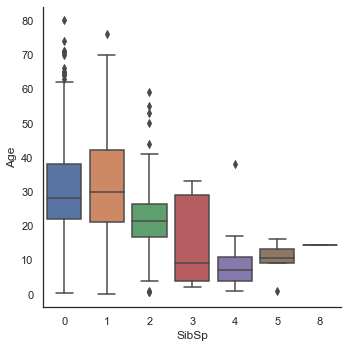

In [41]:
g = sns.factorplot(y='Age', x='Sex', data = dataset, kind = 'box')
g = sns.factorplot(y='Age', x='Sex', hue = 'Pclass', data = dataset, kind = 'box')
g = sns.factorplot(y='Age', x= 'Parch', data = dataset, kind = 'box')
g = sns.factorplot(y='Age', x= 'SibSp', data = dataset, kind = 'box')

- 나이와 성별은 나이를 예측하는 데 그닥 도움이 되지 않는 것 같다.
- 1등석 승객은 2등석 승객보다 나이가 많고, 3등석 승객보다 나이가 더 많은 것 같다. 아무래도 나이가 많으면 돈이 많아서 그런가.
- +로, 승객은 나이가 많을수록 부모,자식을 더 많이 가지고 있고 형제자매는 더 적게 가지고 있는 것 같다.

In [42]:
# 성별을 categorical로 분류
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

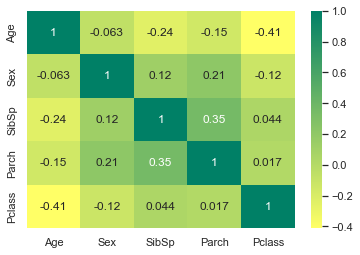

In [43]:
g = sns.heatmap(
        dataset[['Age','Sex','SibSp','Parch', 'Pclass']].corr(), cmap = 'summer_r',annot = True)

- correlation map은 Parch를 제외한 인자 그림의 관측치를 확인한다. 
- Age는 Sex와 관련이 없지만, Pclass, Parch, SibSp와 부정적으로 상관관계가 있다.
- Age는 부모/자녀 수에 따라 상승하는 것을 시각화로 확인했지만 상관관계 자체는 부정적이다.
- 그래서 나는 SibSp, Parch, Pclass를 이용해서 Null Age 를 귀속시키기로 결정
- Pclass, Parch, SibSp에 따라서 비슷한 행의 중위연령으로 Age를 채우는 전략

In [44]:
# Filling missing value of age

# Fill aAge with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows

index_NaN_Age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_Age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & 
                               (dataset['Parch'] == dataset.iloc[i]['Parch']) &
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset["Age"].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

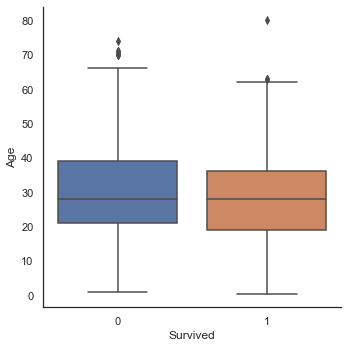

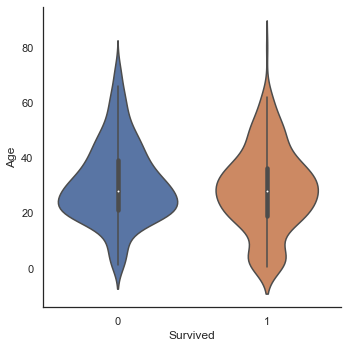

In [45]:
g = sns.factorplot(x = 'Survived', y ="Age", data = train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data= train, kind = 'violin')

- 연령의 중위수 값과 하위 모집단에서의 중위수 간의 차이는 없었다.
- 그러나 생존한 승객들의 violin plot에서 우리는 여전히 매우 어린 승객들이 더 높은 생존률을 가진다는것을 확인할 수 있다.

## Feature Engineering

### Name & Title

In [46]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름에는 승객의 칭에 대한 정보가 포함되어 있다.<br>
칭호에 따라서 대피되는 정도가 다를 수 있다. <br><br>
- Mr : Mister 남자에게 붙이는 칭호
- Miss : 결혼하지 않은 여성에게 붙이는 칭호 
- Mrs : mistress 결혼한 여성에게 붙이는 칭호
- Ms : 미즈. 결혼여부에 관계없이 이름이나 성에 붙이는 칭호
- Dr : 닥터

In [47]:
# get title from name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset["Name"]]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title']

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1294        Mr
1295      Dona
1296        Mr
1297        Mr
1298    Master
Name: Title, Length: 1299, dtype: object

In [48]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

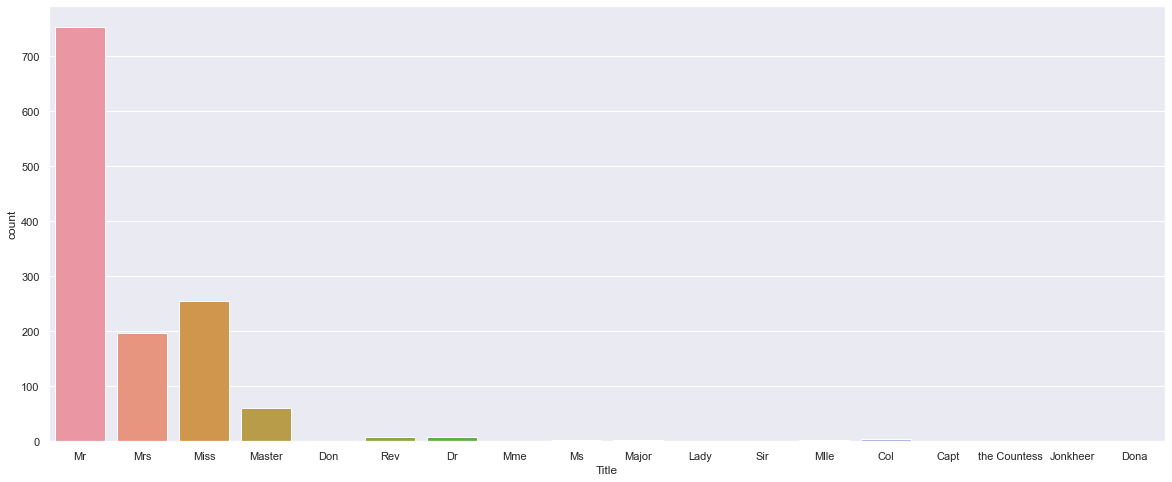

In [49]:
sns.set(rc = {'figure.figsize':(20,8)})
g = sns.countplot(x = 'Title', data = dataset)

타이틀이 여러개이다. Mr 가 수가 가장 많은 것을 확인할 수 있다.

In [50]:
# Convert to categorical values Title
dataset["Title"] = dataset["Title"].replace(
    ['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

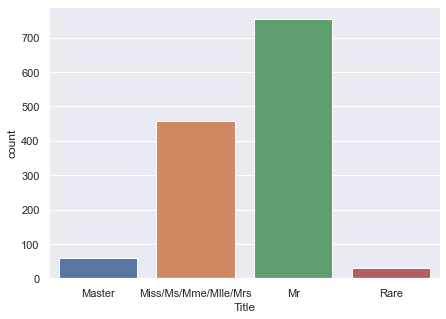

In [51]:
sns.set(rc = {'figure.figsize':(7,5)})
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs',"Mr","Rare"])

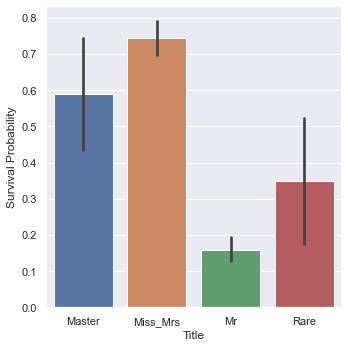

In [52]:
g = sns.factorplot(x = 'Title', y = 'Survived', data=dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss_Mrs', 'Mr',"Rare"])
g = g.set_ylabels('Survival Probability')

- 여자와 아이들이 먼저이다. 여자 칭호가 더 많이 살아남은 것을 확인할 수 있다.
- 희귀한 title이 더 생존률이 높은데, 이는 그냥 사람 수가 얼마 없어서 그럴 수 있다는 확률을 배제할 수는 없다.

In [53]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis=1, inplace = True)

### Family Size

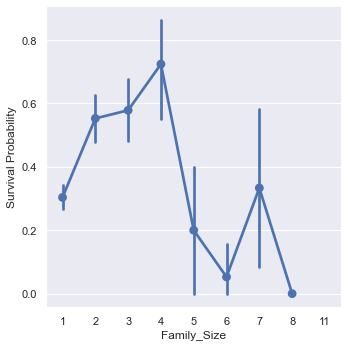

In [54]:
# create a family size descriptor from SibSp, and Parch
dataset['Family_Size'] = dataset['SibSp'] + dataset['Parch'] + 1
g = sns.factorplot(x = 'Family_Size', y='Survived', data = dataset)
g = g.set_ylabels("Survival Probability")

대가족일수록 생존률이 줄어드는 것을 확인했다. 노인이 많아서 그런가..? <br>
4개의 가족 사이즈를 만들기로 했다.

In [55]:
# create new feature of family size
dataset['Single'] = dataset['Family_Size'].map(lambda s : 1 if s==1 else 0)
dataset['SmallF'] = dataset['Family_Size'].map(lambda s : 1 if s==2 else 0)
dataset['MedF'] = dataset['Family_Size'].map(lambda s : 1 if 3 <= s <=4 else 0)
dataset['LargeF'] = dataset['Family_Size'].map(lambda s : 1 if s >= 5 else 0)

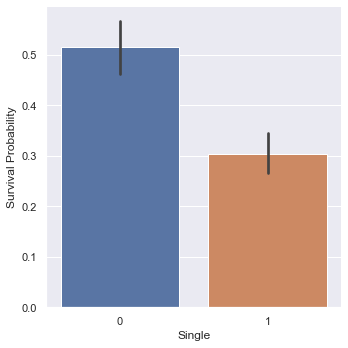

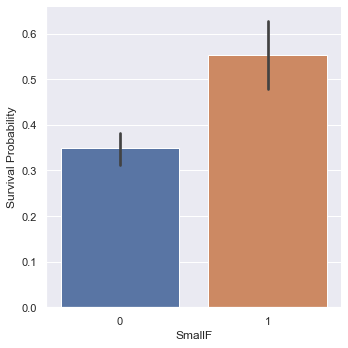

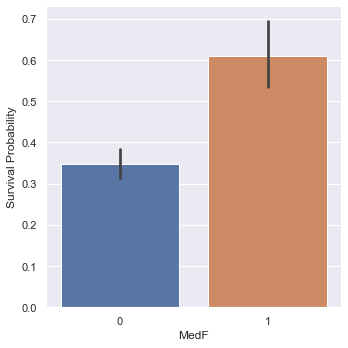

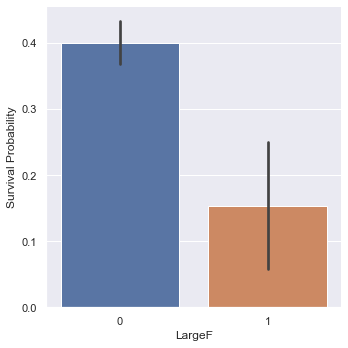

In [56]:
g = sns.factorplot(x= "Single", y='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = 'SmallF', y='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = 'MedF', y='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x = 'LargeF', y='Survived', data = dataset, kind = 'bar')
g = g.set_ylabels("Survival Probability")

중~소 가족이 생존률이 높고, Single 이나 대가족은 생존률이 낮다. <br>
노인 생존이 적어서 그런가.. (노인들이 대가족이 많았음, 근데 형제자매는 낮았는뎅)

## One-Hot Encoding

In [57]:
# Convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [58]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### Cabin

In [59]:
dataset['Cabin']

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1294     NaN
1295    C105
1296     NaN
1297     NaN
1298     NaN
Name: Cabin, Length: 1299, dtype: object

In [60]:
dataset['Cabin'].describe()
# 다 다르노

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [61]:
dataset['Cabin'].isnull().sum()

1007

In [62]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

선실의 첫 번째 글자는 데스크를 가르키며, 타이타닉호에서 승객의 위치를 나타내기 때문에 난 이 정보만을 보관하기로 했다.

In [63]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else "X" for  i in dataset['Cabin'] ])

In [64]:
dataset['Cabin'].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

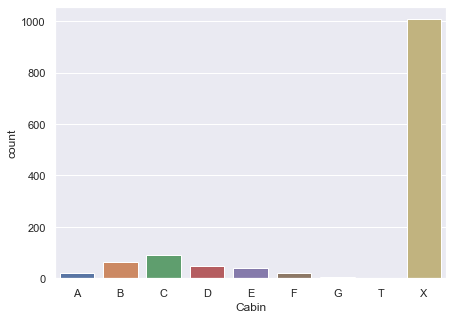

In [65]:
g = sns.countplot(dataset['Cabin'], order = ['A','B','C','D','E','F','G','T','X'])

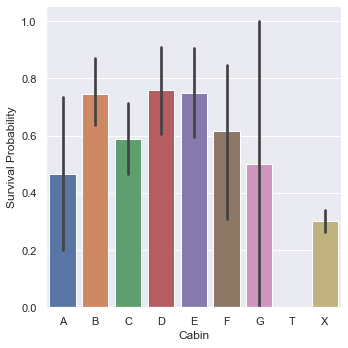

In [66]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar',order = ['A','B','C','D','E','F','G','T','X'] )
g = g.set_ylabels("Survival Probability")

- 객실 정보를 가지고 있는 승객의 수가 적기 때문에 (292명) 생존 확률은 중요한 표준 편차를 가지고 있고, 우리는 다른 DESK에 있는 승객의 생존 확률을 구별할 수 없다.
- 그런ㅏ 우리는 객실을 가진 승객들이 객실이 없는 승객들보다 일반적으로 더 살아남을 기회가 많다는 것을 알 수 있다. 
- 특히 객실 B,C,D,E,F 가 해당한다.

In [67]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

### Ticket

In [68]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 접두사가 있는 것도 있고 없는 것도 있고 ..
- 같은 접두사를 공유하는 티켓이 함께 배치된 선실에 예약될 수 있다는 것을 의미할 수도 있다. 따라서 이것은 배 안에 선실을 실제로 배치하는 것으로 이어질 수 있다.
- 동일한 접두사를 가진 티켓은 등급과 생존이 유사할 수 있다.
- 티켓 기능 열을 접두사로 바꾸기로 해보자.

In [69]:
Ticket = []
for i in list(dataset.Ticket) :
    if not i.isdigit() :
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else :
        Ticket.append('X')
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [70]:
dataset['Ticket'].unique()

array(['A5', 'PC', 'STONO2', 'X', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'STONO', 'C', 'SCPARIS',
       'SOP', 'Fa', 'LINE', 'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH',
       'AS', 'SOPP', 'FC', 'SOTONO2', 'CASOTON', 'SCA3', 'STONOQ', 'AQ4',
       'A', 'LP', 'AQ3'], dtype=object)

In [71]:
dataset= pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')
# prefix = columns 이름 앞에 붙을 prefix 를 정의

In [72]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = "Pc")

In [73]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [74]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Family_Size,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [75]:
dataset.columns

Index(['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size',
       'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1', 'Title_2',
       'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_X', 'T_A',
       'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C', 'T_CA', 'T_CASOTON',
       'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC', 'T_PP', 'T_PPP',
       'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW', 'T_SCPARIS',
       'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2', 'T_SOTONOQ',
       'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP', 'T_WC', 'T_WEP',
       'T_X', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype='object')

# Modeling

In [76]:
# Seperate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len :]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

In [77]:
## Seperate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'],axis=1)

## Simple Modeling <br>
<hr>

### Cross Validate models <br>
- SVC
- Dicision Tree
- AdaBoost
- RandomForest
- Extra Trees
- Gradient Boosting
- Multiple layer perception (neural network)
- KNN
- Logistic Regression
- Lineaar Discriminant Analysis

In [78]:
# Cross Validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)
# Kfold 로 교차검증 진행

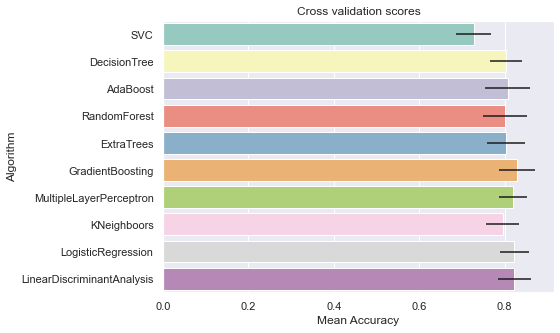

In [79]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train,
                                      y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["SVC", "DecisionTree", "AdaBoost",
                                                                                          "RandomForest", "ExtraTrees", "GradientBoosting", "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression", "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res,
                palette="Set3", orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

## Hyperparameter tunning for best models

AdaBoost, ExtraTree, RandomForest, GradientBoosting 및 SVC에 대한 GreedSearch 진행

In [82]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion": ["gini", "entropy"],
                  "base_estimator__splitter":   ["best", "random"],
                  "algorithm": ["SAMME", "SAMME.R"],
                  "n_estimators": [1, 2],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid,
                        cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [84]:
gsadaDTC.best_score_

0.8275536261491316

In [88]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth" : [None],
                'max_features' : [1,3,10],
                'min_samples_split' : [2,3,10],
                'min_samples_leaf' : [1,3,10],
                'bootstrap' : [False],
                'n_estimators' : [100,300],
                'criterion' : ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=kfold, scoring = 'accuracy',
                     n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [90]:
gsExtC.best_score_

0.8297242083758938

In [92]:
# RandomForest Classifier

RFC = RandomForestClassifier()

rf_param_grid = {'max_depth' :  [None],
                'max_features' : [1,3,10],
                'min_samples_split' : [2,3,10],
                'min_samples_leaf' : [1,3,10],
                'bootstrap' : [False],
                'n_estimators' : [100,300],
                'criterion' : ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy',
                    n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [94]:
# best score
gsRFC.best_score_

0.8354315628192033

In [95]:
# Gradient Boosting

GBC = GradientBoostingClassifier()

gb_param_grid = {'loss' : ['deviance'],
                'n_estimators' : [100,200,300],
                'learning_rate' : [0.1,0.05, 0.01],
                'max_depth' : [4,8],
                'min_samples_leaf' : [100,150],
                'max_features' : [0.3,0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy',
                    n_jobs = 4, verbose = 1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


In [96]:
gsGBC.best_score_

0.8308605720122575

In [98]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel' : ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C':[1, 10, 50, 100, 200, 300, 1000]}
gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring='accuracy', n_jobs = 4, verbose = 1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

In [101]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_score_mean = np.mean(train_scores, axis=1)
    train_score_std = np.std(train_scores, axis=1)
    test_score_mean = np.mean(test_scores, axis=1)
    test_score_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_score_mean - train_score_std, train_score_mean + train_score_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_score_mean - test_score_std, test_score_mean + test_score_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_score_mean, 'o-', color = 'r', label = 'Training score')
    plt.plot(train_sizes, test_score_mean, 'o-', color = 'g', label = 'Cross-validation score')
    
    plt.legend(loc = 'best')
    return plt

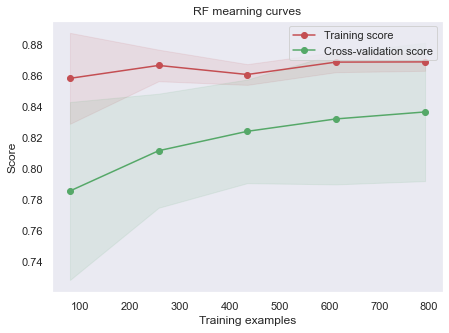

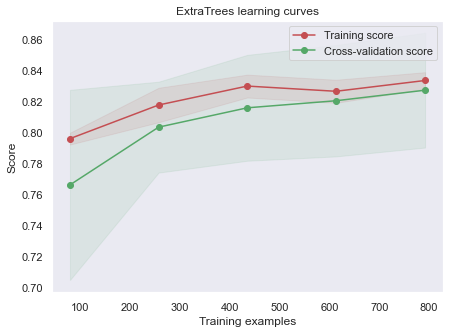

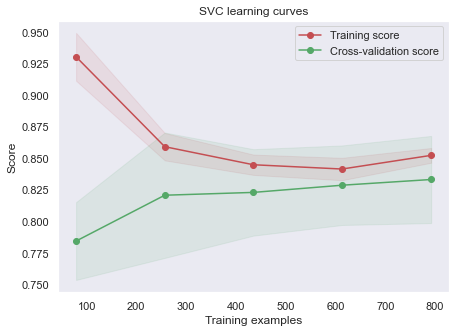

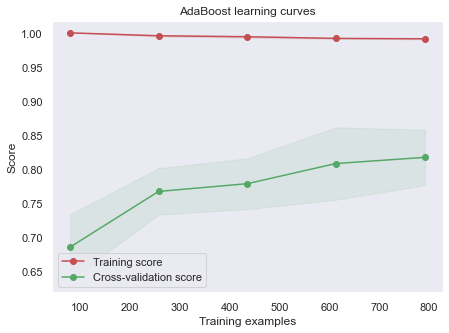

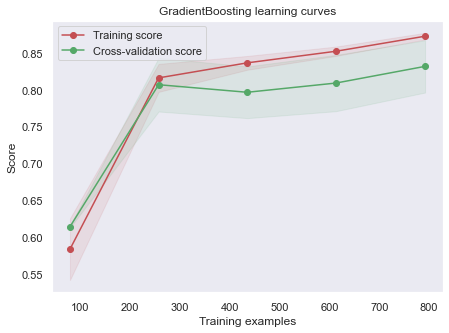

In [102]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

- Gradient Boosting 과 AdaBoost는 훈련셋에 오버핏되는 경향이 있다.
- 교차검증 곡선에 따라 BradientBoosting과 Adaboost는 더 많은 훈련사례를 통해 더 나은 성과를 낼 수 있다.
- SVC와 ExtraTree 분류자는 훈련 곡선과 교차검증곡선이 서로 가깝기 때문에 예측을 더 잘 일반화시킨다.

## Feature Importance of tree based classifiers

- 승객 생존 예측에 가장 유용한 기능을 보기 위해 4개의 트리 기반 분류기에 대한 기능 중요도 표시

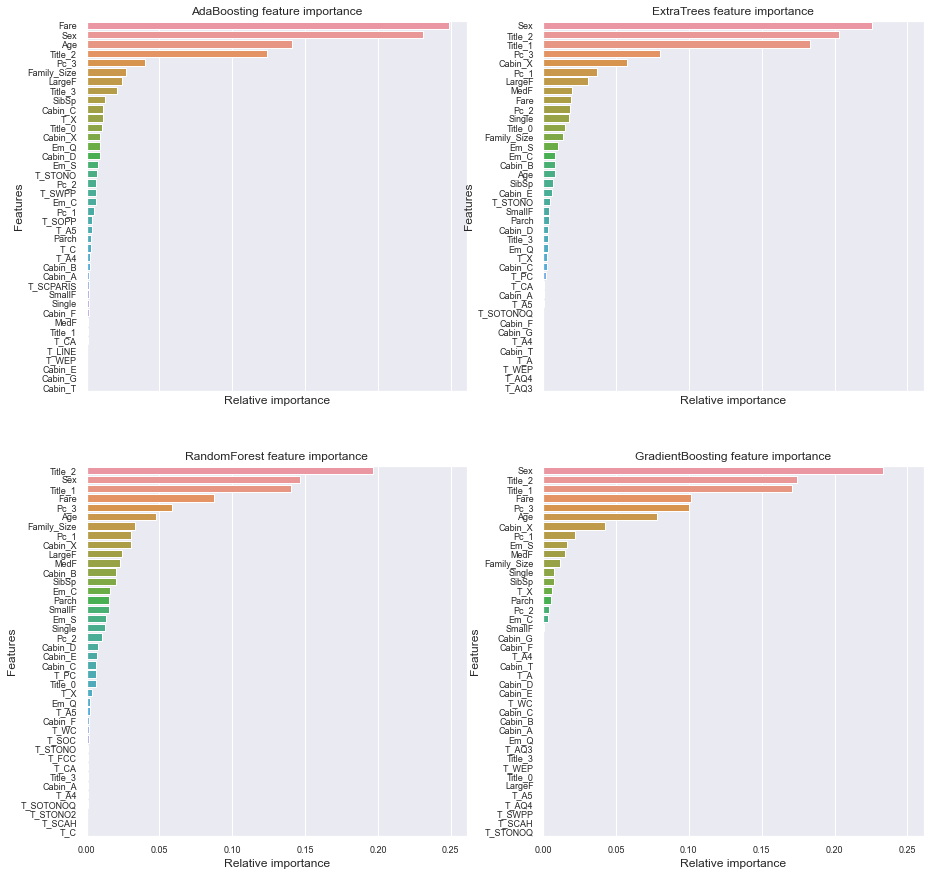

In [106]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1     

- 4개의 트리 기반 분류기에 대한 변수 중요도 표시
- 4개의 분류기가 상대적 중요도에 따라 상위 특징을 가지고 있다는 것을 주목한다.
- 이들의 에측이 같은 특징을 바탕으로 한 것이 아니라는 것이다. 그럼에도 불구하고 공통된 중요한 특징들은 'Par', 'Title_2', 'Age', 'Sex' 등이었다.
- Title_2 는 Mrs/Mme/Miss/Ms 범주인데, 이가 Sex와 높은 상관관계를 가지고 있음을 나타낸다.
<br><br>
정리를 해보면 , 우리는 이와 같이 말할 수 있다.
- pc_1, pc_2, pc_3 및 운임은 승객의 일반적인 사회적 지위를 말한다.
- Sex and Title_2(Mrs/Mlle/Mme/Miss/Ms) 와 Title_3 은 성별을 가르킨다.
- Age 및 Title_1 (Master) 는 승객의 나이를 말한다. (Master는 소년을 가르키는 칭호이다.)
- FSize , LargeF, MedF, Single 은 가족의 크기를 말한다.
- 이 4가지 분류기의 특징적인 중요성에 따라서 생존 예측은 배 안의 위치보다 '나이', '성', 가족규모',
'승객의 사회적지위' 와 더 관련이 있는 것으로 보인다.

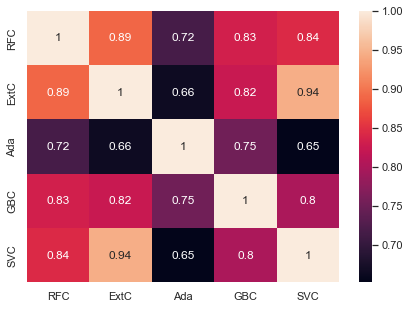

In [107]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

- 이 예측은 AdaBoost 를 제외하고는 나머지 분류기들은 상당히 유사함을 보였다.
- 5개의 분류기들은 거의 같은 예측을 하지만 약간의 차이가 있다.
- 5개 분류기들의 차이점은 종합 투표를 고려하기에 충분하다.

# Esemble Modeling

In [112]:
# 각 모델별 best param 을 뽑고, voting 을 시킨다.
votingC = VotingClassifier(estimators = [('rfc', RFC_best), ('extc', ExtC_best),
                ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)],
                          voting = 'hard', n_jobs = 4)

votingC.fit(X_train,Y_train)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=3,
                                                     min_samples_leaf=3)),
                             ('extc',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=10,
                                                   min_samples_split=3,
                                                   n_estimators=300)),
                             ('svc', SVC(C=10, gamma=0.01, probability=True)),
                             ('adac',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                                                 learning_rate=0.3,
                                                 n_estimators=2,
                                                 random_state=7)),
                             ('gbc',
                              GradientBoostingClassifier(loss='deviance',
                                                         max_depth=8,
                                                         max_features=0.3,
                                                         min_samples_leaf=100,
                                                         n_estimators=300))],
                 n_jobs=4)

In [113]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("./03.ensemble_python_voting.csv",index=False)

In [111]:
votingC.best_score_

AttributeError: 'VotingClassifier' object has no attribute 'best_score_'